In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as xcept_preproc

from load_and_preprocess_data import TrainDataInfo

In [5]:
%load_ext autoreload
%autoreload 2

In [2]:
%%writefile training_utils.py
import cv2
import os
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as xcept_preproc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from load_and_preprocess_data import TrainDataInfo
from image_utilities import ImageUtilities
from matplotlib.ticker import MaxNLocator

# This is a light wrapper that holds the TrainDataInfo object, and has some basic utils
class TrainingUtils:
    def __init__(self, all_train_info, img_size_3d, batch_size):
        self.train_info = all_train_info
        self.num_countries = len(all_train_info.country_names)
        csizes =  [len(all_train_info.filename_map[c]) for c in all_train_info.country_names]
        self.total_file_count = sum(csizes)
        self.img_size_3d = img_size_3d
        self.img_size_2d = img_size_3d[:2]
        self.batch_size = batch_size
        
        
    def indices_to_labels(self, y_idxs):
        return [self.train_info.country_names[y] for y in y_idxs]
    
    
    def indices_to_labels_disp(self, y_idxs):
        return [self.train_info.country_names_disp[y] for y in y_idxs]
    
    
    def print_classification_report(self, y_true, y_pred):
        y_true_lbl = self.indices_to_labels(y_true)
        y_pred_lbl = self.indices_to_labels(y_pred)
        print(sklearn.metrics.classification_report(y_true_lbl, y_pred_lbl))
        

    def display_heatmaps(self, y_true, y_pred):
        y_true_lbl = self.indices_to_labels_disp(y_true)
        y_pred_lbl = self.indices_to_labels_disp(y_pred)
        fig,axs = plt.subplots(1,2, figsize=(16,8))
        cm = sklearn.metrics.confusion_matrix(y_true_lbl, y_pred_lbl)
        cm_norm = (cm.T / np.sum(cm, axis=1)).T
        sns.heatmap(cm, annot=True, ax=axs[0], linewidths=0.5, cbar=False)
        sns.heatmap(cm_norm, annot=True, ax=axs[1], linewidths=0.5, cbar=False)
        for i in range(2):
            axs[i].set_xticks(np.arange(self.num_countries)+0.5)
            axs[i].set_xticklabels(self.train_info.country_names_disp)
            axs[i].set_yticks(np.arange(self.num_countries)+0.5)
            axs[i].set_yticklabels(self.train_info.country_names_disp)
            axs[i].set_xlabel('Predicted Label')
            axs[i].set_ylabel('Actual Label')
            axs[i].xaxis.set_ticks_position('top')
            axs[i].xaxis.set_label_position('top')
            plt.setp(axs[i].get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
            plt.setp(axs[i].get_yticklabels(), rotation=0, va="top") 
        axs[0].set_title('Confusion Matrix (Unscaled)')
        axs[1].set_title('Confusion Matrix (Normalized)')
        fig.tight_layout(pad=3.0)
        
        
    def display_training_hist(self, hist):
        fig, axs = plt.subplots(1,2, figsize=(12,6))
        axs[0].plot(hist.history['loss'], label='Training Loss')
        axs[0].plot(hist.history['val_loss'], label='Testing Loss')
        axs[0].set_ylim(bottom=0)
        axs[0].legend()
        axs[1].plot(hist.history['accuracy'], label='Training accuracy')
        axs[1].plot(hist.history['val_accuracy'], label='Testing accuracy')
        axs[1].set_ylim([-0.05, 1.05])
        axs[1].legend()
        axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        
        
    def train_data_generator_disk(self,
        train_split_index,
        img_size_2d,
        use_sample_weighting=False,
        label_smoothing_value=0.05,
        preproc_func=lambda x: x):

        """
        The train_info object has indexed all the filenames for all available data. 
        It has precomputed sampling probabilities, sample weights, and train-test splits
        Supply label_smoothing_value=0 to disable it
        For preproc_func we'll supply the inception_v3 preprocess_inputs function
        """

        def out_generator():
            file_map = self.train_info.traintest_splits[train_split_index]['train']
            total_ct = sum([len(file_map[c]) for c in file_map.keys()])

            # Consider the total image count 1 epoch, even though not all images will be sampled
            for i in range(total_ct):
                img_path, country_idx = self.train_info.sample_filename('train', train_split_index)
                sample_wgt = self.train_info.weight_scalars[country_idx]

                img = ImageUtilities.load_image(img_path, preproc_func)
                img = ImageUtilities.augment_image(img, resize_to=img_size_2d)

                ans = np.zeros(shape=(self.num_countries,), dtype='float32')
                ans = ans + label_smoothing_value
                ans[country_idx] = 1.0 - label_smoothing_value

                if use_sample_weighting:
                    yield (img, ans, sample_wgt)
                else:
                    yield (img, ans)

        return out_generator


    def train_data_generator_memory(self,
        train_split_index,
        img_size_2d,
        use_sample_weighting=False,
        label_smoothing_value=0.05,
        preproc_func=lambda x: x):
    
        """
        This method is same as above, but loads all training images into memory (before
        augmentation).  This is pretty heavy for most systems, thus the previous version
        that loads from disk on-the-fly is available and tested.

        The train_info object has indexed all the filenames for all available data. 
        It has precomputed sampling probabilities, sample weights, and train-test splits
        Supply label_smoothing_value=0 to disable it
        For preproc_func we'll supply the inception_v3 preprocess_inputs function
        """

        file_map = self.train_info.traintest_splits[train_split_index]['train']
        print(f'Filling image cache')
        image_cache = {}
        for country in self.train_info.country_names:
            for f in file_map[country]:
                image_cache[f] = ImageUtilities.load_image(f, preproc_func)

        def out_generator():
            total_ct = len(image_cache)
            # Consider the total image count 1 epoch, even though not all images will be sampled
            for i in range(total_ct):
                img_path, country_idx = self.train_info.sample_filename('train', train_split_index)
                sample_wgt = self.train_info.weight_scalars[country_idx]

                img = image_cache[img_path]
                img = ImageUtilities.augment_image(img, resize_to=img_size_2d)

                ans = np.zeros(shape=(self.num_countries,), dtype='float32')
                ans = ans + label_smoothing_value
                ans[country_idx] = 1.0 - label_smoothing_value

                if use_sample_weighting:
                    yield (img, ans, sample_wgt)
                else:
                    yield (img, ans)

        return out_generator


    def generator_to_dataset(self,
        gener_obj,
        img_size_3d,
        n_classes,
        batch_size=32,
        with_sample_weighting=False):
        
        """
        Take a generator produced above and wrap it in a tf.data.Dataset.  
        from_generator requires and image size, hence why it is passed in again.
        """
        if with_sample_weighting:
            out_dataset = tf.data.Dataset.from_generator( 
                gener_obj,
                (tf.float32, tf.float32, tf.float32), 
                (tf.TensorShape(img_size_3d), tf.TensorShape((n_classes,)), tf.TensorShape([])))
        else:
            out_dataset = tf.data.Dataset.from_generator( 
                gener_obj,
                (tf.float32, tf.float32), 
                (tf.TensorShape(img_size_3d), tf.TensorShape((n_classes,))))

        if batch_size:
            out_dataset = out_dataset.batch(batch_size)

        return out_dataset


    def create_test_dataset(self,
        test_split_index,
        img_size_3d,
        preproc_func=lambda x: x,
        batch_size=1):
        
        """
        This just iterates through all images, in order, on the test side of the split.
        No augmentation is applied to the test dataset
        Default batch_size=1 because it avoids OOM problems, and it's not bad for 145 test images
        """

        def gen_func():
            file_map = self.train_info.traintest_splits[test_split_index]['test']
            for c_idx in range(self.num_countries):
                country = self.train_info.country_names[c_idx]
                for img_path in file_map[country]:
                    img = ImageUtilities.load_image(img_path, preproc_func)
                    img = cv2.resize(img, img_size_3d[:2])
                    ans = np.zeros(shape=(self.num_countries,), dtype='float32')
                    ans[c_idx] = 1.0
                    yield (img, ans)

        return self.generator_to_dataset(gen_func, img_size_3d, self.num_countries, batch_size, with_sample_weighting=False)

    
    # Iterate over all cross-val splits
    def train_one_fold(self, model_gen_func, kfold_index, epochs=20, optimizer=None, model=None, model_prefix=None):
        """
        Can pass in a pre
        """
        gen = self.train_data_generator_disk(
            kfold_index,
            self.img_size_2d,
            preproc_func=xcept_preproc,
            use_sample_weighting=True)

        train_ds = self.generator_to_dataset(gen, self.img_size_3d, self.num_countries, self.batch_size, with_sample_weighting=True)
        test_ds = self.create_test_dataset(kfold_index, self.img_size_3d, xcept_preproc)

        # Default Nadam
        if optimizer is None:
            optimizer = keras.optimizers.Nadam(1e-4)

        if model is None:
            print(f'Creating new model for fold {kfold_index}')
            model = model_gen_func()
            model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
            
        
        if model_prefix:
             model_prefix = model_prefix.rstrip('_')
        else:
            model_prefix = 'weights'
                
        model_save_file = f'{model_prefix}_kfold_{kfold_index}.hdf5'
        
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
        mcp_save = ModelCheckpoint(model_save_file, save_best_only=True, monitor='val_loss', mode='min')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=8, verbose=1, mode='min')

        training_history = model.fit(
            x=train_ds,
            epochs=epochs,
            validation_data=test_ds,
            callbacks=[mcp_save, reduce_lr])

        model.load_weights(filepath = model_save_file)
        true_labels = []
        pred_labels = []
        for batch in test_ds:
            img_batch, label_batch = batch 
            calc_labels = model(img_batch).numpy()
            true_labels.append(np.argmax(label_batch, axis=1))
            pred_labels.append(np.argmax(calc_labels, axis=1))

        true_labels = np.concatenate(true_labels, axis=0)
        pred_labels = np.concatenate(pred_labels, axis=0)
        return model, true_labels, pred_labels, training_history
    
    
    def train_eval_kfold_crossval(self, model_gen_func, epochs=20, model_prefix=None):
        """
        Input is a model that takes a batch of [_, 299, 299, 3] images & produces [_, 11] outputs
        """
        true_labels = []
        pred_labels = []
        models = []
        train_hist = []
        hist = None
        for kfold_index in range(5):
            model, fold_true, fold_pred, hist = self.train_one_fold(model_gen_func, kfold_index, epochs, model_prefix=model_prefix)

            true_labels.extend(fold_true)
            pred_labels.extend(fold_pred)
            models.append(model)
            train_hist.append(hist)

        # Returns last model and training_history, all true/pred labels for all images
        #self.display_training_hist(train_hist[-1])
        return model, true_labels, pred_labels, train_hist
    
    
    def create_feature_extractor_model(self, intermediate_layer_idxs=None):
        if intermediate_layer_idxs is None:
            intermediate_layer_idxs = [45, 65, 95]
            
        fex_base = Xception(weights='imagenet', include_top=False)
        inp_layer = fex_base.layers[0].input
        inner_layer_outputs = [fex_base.layers[l].output for l in intermediate_layer_idxs]
        out_layer = fex_base.layers[-1].output

        all_avg_outs = [L.GlobalAveragePooling2D()(lout) for lout in (inner_layer_outputs + [out_layer])]
        combined = L.Concatenate(axis=-1)(all_avg_outs)

        return keras.models.Model(inputs=inp_layer, outputs=combined)
        
        
    def extract_features_to_disk(self, fex_model, train_ds, test_ds, out_file_prefix, train_repeat=6):
        """
        This will return integer classes (not one-hot-encoded)
        If this uses the standard training-generator defined above, it will sample
        the images according to the adjusted sampling distribution.  It's possible
        not all images will be sampled
        """
        
        img_wgts = None
        features, labels = [], []
        for batch in train_ds.repeat(train_repeat):
            img_batch, img_lbls = batch
                    
            n_samples = img_batch.shape[0]
            features.append(fex_model.predict_on_batch(img_batch).numpy().reshape([n_samples, -1]))
            labels.append(img_lbls.numpy().reshape([n_samples, -1]))
            
        all_features = np.concatenate(features, axis=0)
        all_labels = np.argmax(np.concatenate(labels, axis=0), axis=1)   
        
        print(f'Full set of training features and labels: {all_features.shape} and {all_labels.shape}')
        np.save(f'{out_file_prefix}_train_features', all_features)
        np.save(f'{out_file_prefix}_train_labels', all_labels)

        
        features, labels = [], []
        for batch in test_ds:
            img_batch, img_lbls = batch
            n_samples = img_batch.shape[0]
            features.append(fex_model.predict_on_batch(img_batch).numpy().reshape([n_samples, -1]))
            labels.append(img_lbls.numpy().reshape([n_samples, -1]))
            
        all_features = np.concatenate(features, axis=0)
        all_labels = np.argmax(np.concatenate(labels, axis=0), axis=1)   
        
        print(f'Full set of testing features and labels: {all_features.shape} and {all_labels.shape}')
        np.save(f'{out_file_prefix}_test_features', all_features)
        np.save(f'{out_file_prefix}_test_labels', all_labels)

Overwriting training_utils.py


In [10]:
from training_utils import TrainingUtils
    

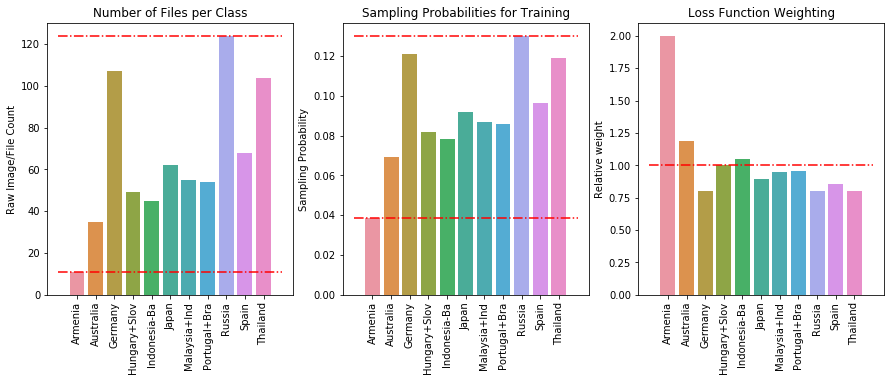

In [8]:
train_info = TrainDataInfo('train_fixed_rotation')
train_info.display_rel_counts()

In [6]:
INPUT_IMG_SIZE_3 = (299, 299, 3)
INPUT_IMG_SIZE_2 = INPUT_IMG_SIZE_3[:2]
NUM_COUNTRIES = len(train_info.country_names)
BATCH_SIZE = 16

train_utils = TrainingUtils(train_info, INPUT_IMG_SIZE_3, batch_size=BATCH_SIZE)

In [7]:
_ = '''
INTERMEDIATE_LAYERS = [45, 65, 95]
# Just testing the model creation between inputs and an intermediate layer
for layer_idx in INTERMEDIATE_LAYERS:
    short_model = keras.models.Model(
        inputs=fex_model.layers[0].input,
        outputs=fex_model.layers[layer_idx].output)

    zeros_img = np.zeros(shape=(1,) + INPUT_IMG_SIZE_3, dtype='float32')
    print_output_shape(short_model)
'''
    

In [8]:
multi_out_extrafc = train_utils.create_feature_extractor_model()
multi_out_extrafc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
# Create a set of files for each k-fold
for k in range(5):
    # Using these methods to create the generator will do sampling and augmentation
    # according to train_info sampling probabilities and ImageUtilities augment function
    print(f'Extracting features to disk for fold {k}')
    gen = train_utils.train_data_generator_disk(k, INPUT_IMG_SIZE_2)
    train_ds = train_utils.generator_to_dataset(gen, INPUT_IMG_SIZE_3, NUM_COUNTRIES, BATCH_SIZE)
    test_ds = train_utils.create_test_dataset(k, INPUT_IMG_SIZE_3, batch_size=1)
    
    out_file_prefix = f'feature_extractions/xception_with_3_inner_layers__fold_{k}'
    train_utils.extract_features_to_disk(multi_out_extrafc, train_ds, test_ds, out_file_prefix, train_repeat=6)

Extracting features to disk for fold 0
Full set of training features and labels: (3408, 4232) and (3408,)
Full set of testing features and labels: (146, 4232) and (146,)
Extracting features to disk for fold 1
Full set of training features and labels: (3414, 4232) and (3414,)
Full set of testing features and labels: (145, 4232) and (145,)
Extracting features to disk for fold 2
Full set of training features and labels: (3426, 4232) and (3426,)
Full set of testing features and labels: (143, 4232) and (143,)
Extracting features to disk for fold 3
Full set of training features and labels: (3432, 4232) and (3432,)
Full set of testing features and labels: (142, 4232) and (142,)
Extracting features to disk for fold 4
Full set of training features and labels: (3456, 4232) and (3456,)
Full set of testing features and labels: (138, 4232) and (138,)


In [10]:
load_fex = np.load(f'feature_extractions/xception_with_3_inner_layers__fold_{k}_train_features.npy')
load_lbl = np.load(f'feature_extractions/xception_with_3_inner_layers__fold_{k}_train_labels.npy')

In [11]:
print(load_fex.shape, load_lbl.shape)

(3456, 4232) (3456,)


In [ ]:
fig,axs = plt.subplots(4,5, figsize=(15,10))
layers = ['Layer3', 'Layer5', 'Layer8', 'NormalOut']
for r in range(4):
    for c in range(5):
        rnd_idx = np.random.choice(range(r*728, (r+1)*728))
        axs[r][c].hist(load_fex[:,rnd_idx], bins=30)
        axs[r][c].set_title(f'{layers[r]} features')
_ = fig.suptitle('Distribution of random "features" from the Xception network')
# Wondering how well gaussian naive bayes will work with this data... 